# Title

## Introduction

## Preliminary Exploratory Data Analysis

In [1]:
### Run this cell before continuing.
# install.packages("cowplot") ### Only run this once 
library(cowplot)
library(tidyverse)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 6)
source('tests.R')
source('cleanup.R')

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.2     ✔ purrr   1.0.1
✔ tibble  3.2.1     ✔ dplyr   1.1.1
✔ tidyr   1.3.0     ✔ stringr 1.5.0
✔ readr   2.1.3     ✔ forcats 0.5.2
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.2     ✔ rsample      1.1.1
✔ dials        1.1.0     ✔ tune         1.0.1
✔ infer        1.0.4     ✔ workflows    1.1.2
✔ modeldata    1.0.1     ✔ workflowsets 1.0.0
✔ parsnip      1.0.3     ✔ yardstick    1.1.0
✔ recipes      1.0.4     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks read

ERROR: Error in file(filename, "r", encoding = encoding): cannot open the connection


In [2]:
# Load in dataset
heart_data <- read_csv("https://raw.githubusercontent.com/random56428/heart-disease/main/data/heart.csv")
# Mutate target variable into factors
heart_data <- mutate(heart_data, target = as_factor(target))
# Peek the first 6 rows of the dataset
head(heart_data)

Rows: 1025 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (14): age, sex, cp, trestbps, chol, fbs, restecg, thalach, exang, oldpea...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
61,1,0,148,203,0,1,161,0,0.0,2,1,3,0
62,0,0,138,294,1,1,106,0,1.9,1,3,2,0
58,0,0,100,248,0,0,122,0,1.0,1,0,2,1


In [3]:
# Set the seed. Don't remove this!
set.seed(1234567890)

# Randomly split 75% of the data in the training set
heart_split <- initial_split(heart_data, prop = 0.75, strata = target)
heart_train <- training(heart_split)
heart_test <- testing(heart_split)

# heart_split
# heart_train
# heart_test

# Table that reports the number of observations in each class (target) of the training dataset
heart_train |>
    group_by(target) |>
    summarize(count = n())

target,count
<fct>,<int>
0,374
1,394


In [4]:
# Means of the predictor variables
heart_train |>
    select(-target) |>
    summarize(across(everything(), ~ mean(.x, na.rm = TRUE))) |>
    rename_with(~ paste0(., "_mean"))

age_mean,sex_mean,cp_mean,trestbps_mean,chol_mean,fbs_mean,restecg_mean,thalach_mean,exang_mean,oldpeak_mean,slope_mean,ca_mean,thal_mean
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
54.42057,0.6966146,0.9244792,131.6732,245.6068,0.1523438,0.5208333,148.6081,0.3320312,1.070703,1.373698,0.7604167,2.311198


In [5]:
# Amount of cells with missing data
sum(is.na(heart_train))

[1] 0

### Comparison of the distributions of each of the predictor variables

In [6]:
# Generic function to visualize a distribution of a variable in heart_train
#
# @param type - "bar" for geom_bar, "hist" for geom_histogram
# @param variable_name - name of column header - must be in heart_train
# @param x_label - x-axis label
# @param y_label - y-axis label
# @param title - title of the plot
# @param rename_x_labels_to - a vector of strings to rename x labels to
visualize_dist <- function(type, variable_name, x_label, y_label, title, rename_x_labels_to = NULL) {
    # Throw error if variable name does not exist
    if (!(variable_name %in% colnames(heart_train))) {
        stop(variable_name, " not in any of the dataset headers")
    }
    
    # Create a generic table count of variable_name
    count_table <- heart_train |>
        select(contains(variable_name)) |>
        group_by(across(all_of(variable_name))) |>
        summarize(count = n())
    
    # Set type of plot, aesthetics, and table reference
    geom_type <- NULL
    custom_aes <- NULL
    tbl_ref <- NULL
    rename_x_labels <- NULL # Only used for bar plots
    if (type == "bar") {
        geom_type <- geom_bar(stat = "identity", fill = "#78a9f8", color = "black", linewidth = 0.2)
        custom_aes <- aes(x = factor(get(variable_name)), y = count)
        tbl_ref <- count_table
        rename_x_labels <- if (!is.null(rename_x_labels_to)) scale_x_discrete(labels = rename_x_labels_to)
    } else if (type == "hist") {
        geom_type <- geom_histogram(binwidth = 2, fill = "#78a9f8", color = "black", linewidth = 0.2)
        custom_aes <- custom_aes <- aes(x = get(variable_name))
        tbl_ref <- heart_train
    } else {
        stop(type, " geom type not supported")
    }
    
    # Credit for wrapper: https://stackoverflow.com/a/3935429
    wrapper <- function(x, ...) {
        paste(strwrap(x, ...), collapse = "\n")
    }
    
    # Visualize
    res <- ggplot(tbl_ref, custom_aes) +
        geom_type + 
        labs(x = wrapper(x_label, width = 45), y = y_label, title = wrapper(title, width = 45)) +
        theme(text = element_text(size = 10)) + 
        rename_x_labels
    return(res)
}

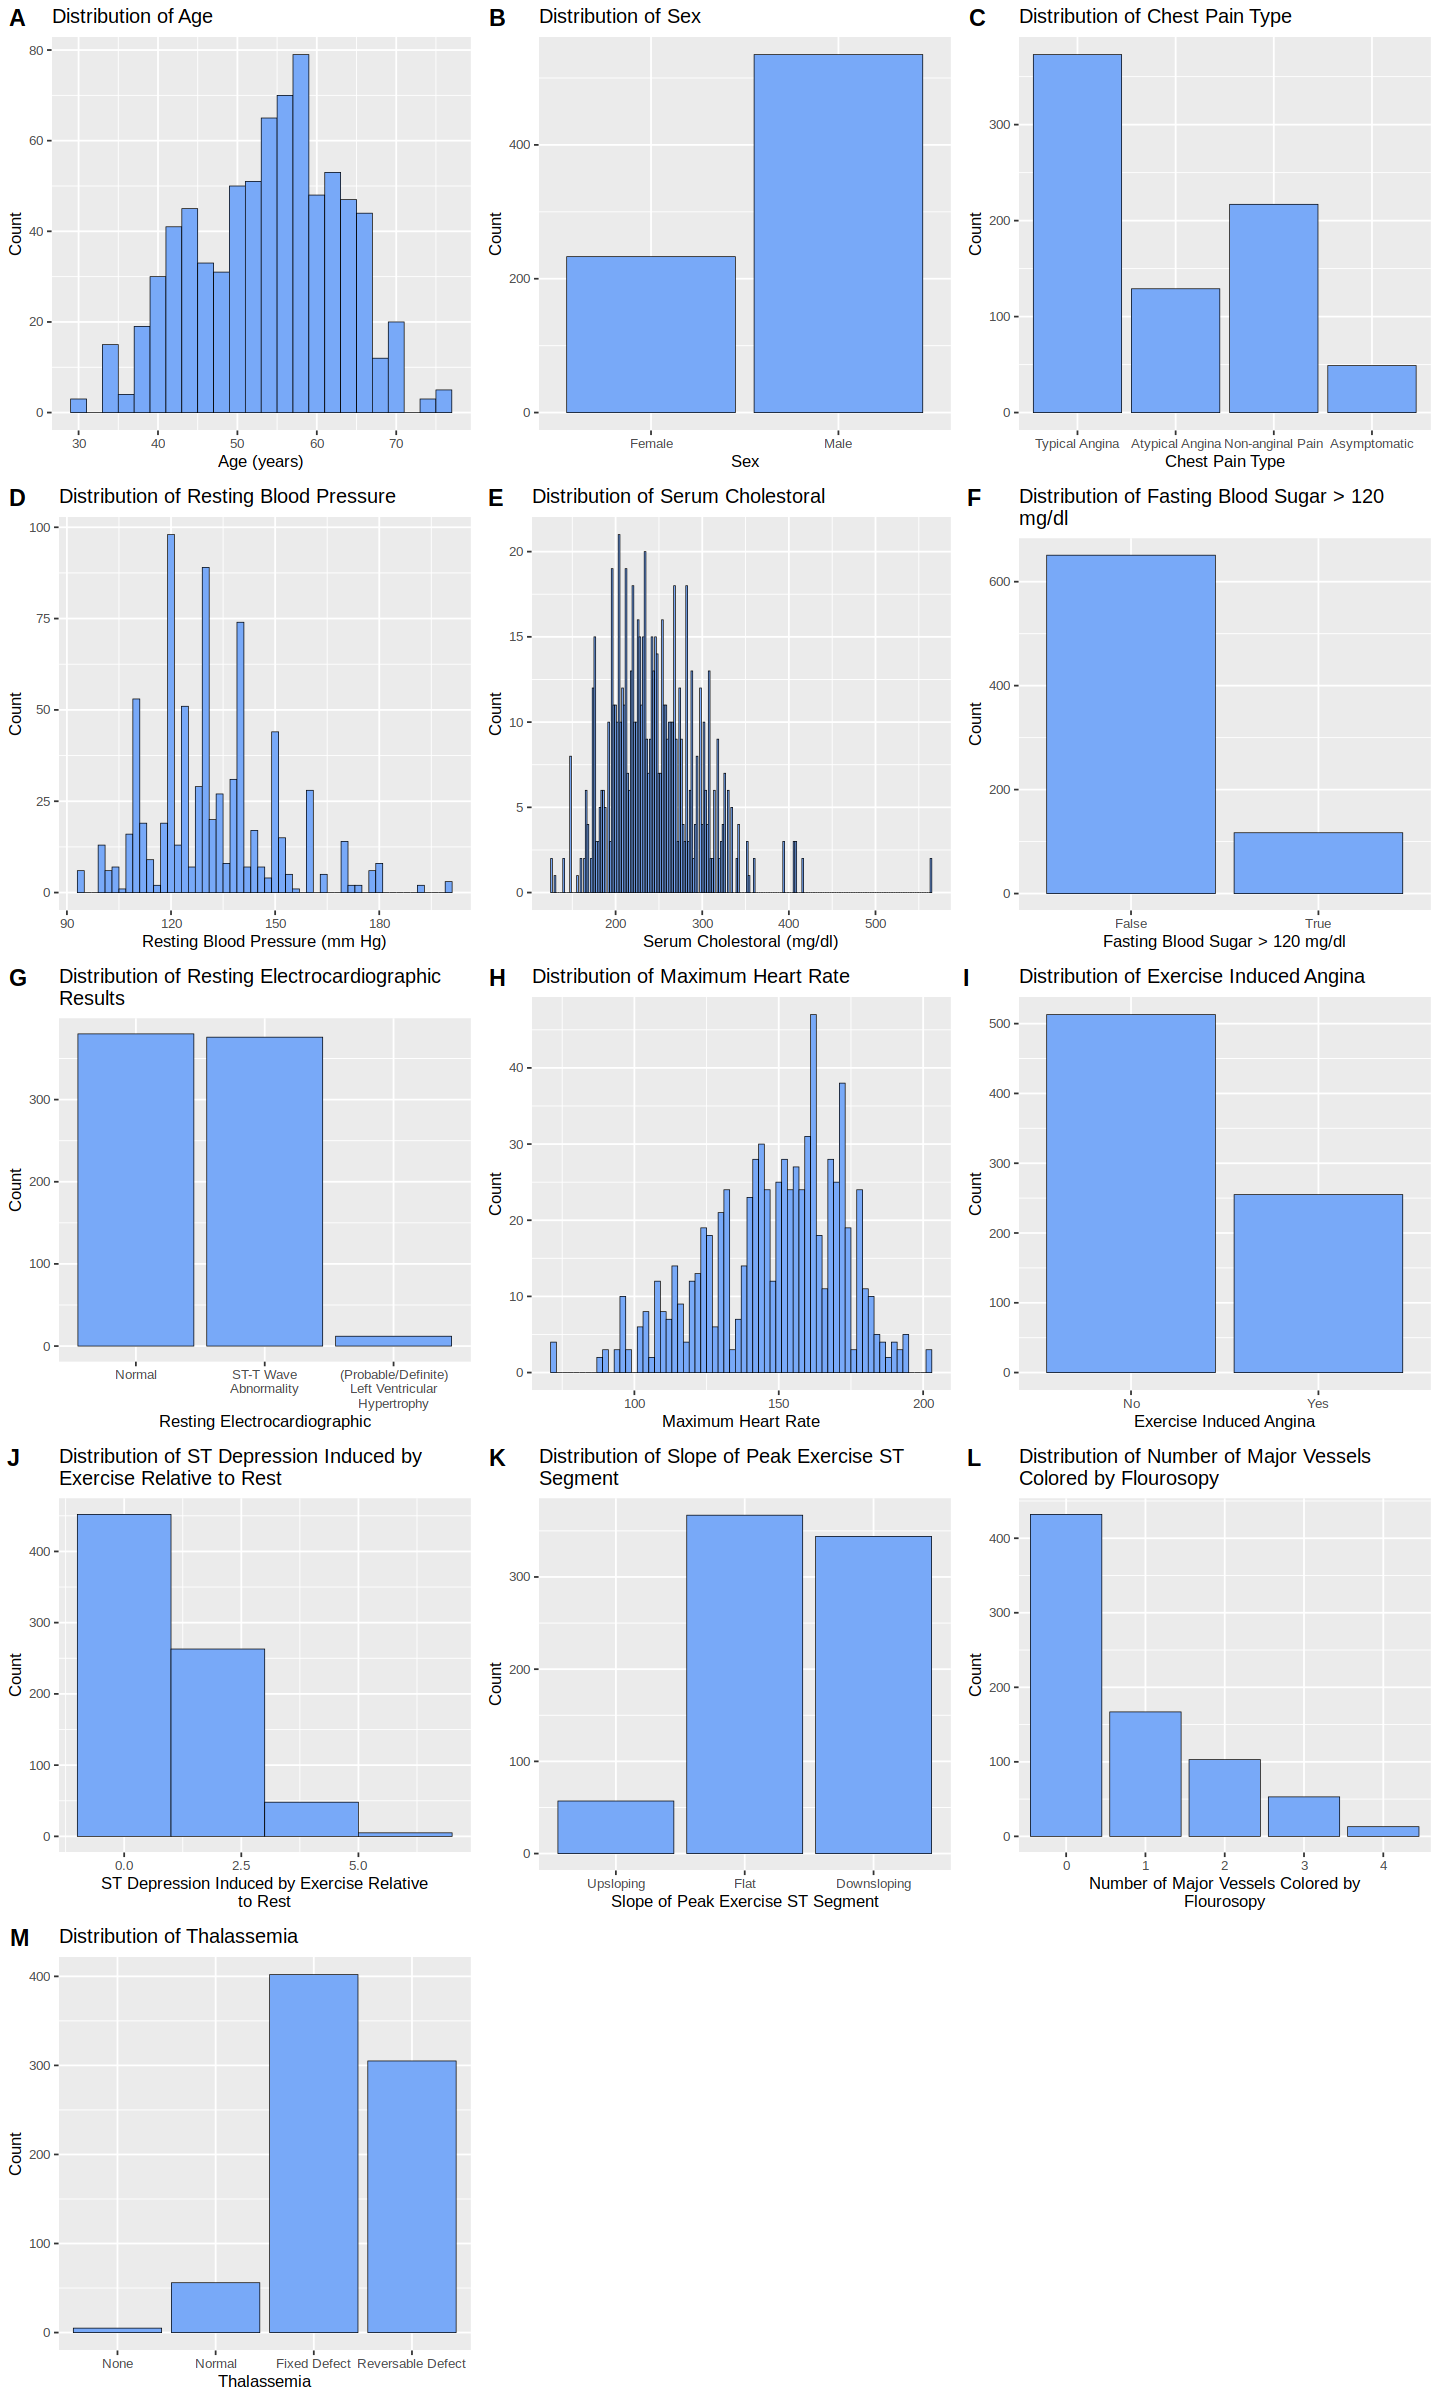

In [256]:
# Set width and height of plot
options(repr.plot.width = 12, repr.plot.height = 20)

plot1 <- visualize_dist("hist", "age", "Age (years)", "Count", "Distribution of Age")
plot2 <- visualize_dist("bar", "sex", "Sex", "Count", "Distribution of Sex", c("Female", "Male"))
plot3 <- visualize_dist("bar", "cp", "Chest Pain Type", "Count", "Distribution of Chest Pain Type", c("Typical Angina", "Atypical Angina", "Non-anginal Pain", "Asymptomatic"))
plot4 <- visualize_dist("hist", "trestbps", "Resting Blood Pressure (mm Hg)", "Count", "Distribution of Resting Blood Pressure")
plot5 <- visualize_dist("hist", "chol", "Serum Cholestoral (mg/dl)", "Count", "Distribution of Serum Cholestoral")
plot6 <- visualize_dist("bar", "fbs", "Fasting Blood Sugar > 120 mg/dl", "Count", "Distribution of Fasting Blood Sugar > 120 mg/dl", c("False", "True"))
plot7 <- visualize_dist("bar", "restecg", "Resting Electrocardiographic", "Count", "Distribution of Resting Electrocardiographic Results", c("Normal", "ST-T Wave\nAbnormality", "(Probable/Definite)\nLeft Ventricular\nHypertrophy"))
plot8 <- visualize_dist("hist", "thalach", "Maximum Heart Rate", "Count", "Distribution of Maximum Heart Rate")
plot9 <- visualize_dist("bar", "exang", "Exercise Induced Angina", "Count", "Distribution of Exercise Induced Angina", c("No", "Yes"))
plot10 <- visualize_dist("hist", "oldpeak", "ST Depression Induced by Exercise Relative to Rest", "Count", "Distribution of ST Depression Induced by Exercise Relative to Rest")
plot11 <- visualize_dist("bar", "slope", "Slope of Peak Exercise ST Segment", "Count", "Distribution of Slope of Peak Exercise ST Segment", c("Upsloping", "Flat", "Downsloping"))
plot12 <- visualize_dist("bar", "ca", "Number of Major Vessels Colored by Flourosopy", "Count", "Distribution of Number of Major Vessels Colored by Flourosopy")
plot13 <- visualize_dist("bar", "thal", "Thalassemia", "Count", "Distribution of Thalassemia", c("None", "Normal", "Fixed Defect", "Reversable Defect"))
plot_grid(plot1, plot2, plot3, plot4, plot5, plot6, plot7, plot8, plot9, plot10, plot11, plot12, plot13, labels = "AUTO", ncol = 3)

## Methods

## Expected Outcomes and Significance